In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import datetime

In [2]:
corr_tiempo_lic = 1/(2*3600)
corr_tiempo_dohm = 15/(3600)

infile_licor = 'R209_inside.txt'
outfile_licor = 'R209_outside.txt'

t_stopinyec_licor = '9:3:00'
t_opendoor_licor = '9:6:00'

infile_dohm = ''
outfile_dohm = ''

t_stopinyec_dohm = ''
t_opendoor_dohm = ''

In [3]:
if len(infile_licor) > 0: 
    licor_IN_df = pd.read_csv(infile_licor, sep="\t", skiprows = [0])
    licor_IN_df.drop(['Unnamed: 8'], axis = 1 , inplace = True)
    licor_IN_df.dropna()
    
if len(outfile_licor) > 0: 
    licor_OUT_df = pd.read_csv(outfile_licor, sep="\t", skiprows = [0])
    licor_OUT_df.drop(['Unnamed: 8'], axis = 1 , inplace = True)
    licor_OUT_df.dropna()
    
if len(infile_dohm) > 0:
    dohm_IN_df = pd.read_csv(infile_dohm, sep=";")
    dohm_IN_df['Hr'] = [hr[11:] for hr in dohm_IN_df["Adquisición"]]
    dohm_IN_df.dropna()
    
if len(outfile_dohm) > 0:
    dohm_OUT_df = pd.read_csv(infile_dohm, sep=";")
    dohm_OUT_df.dropna()

In [4]:
def linear_reg_plot(C, corr_tiempo, start_idx=0, end_idx=-1):

    x = C[start_idx:end_idx].index.values*corr_tiempo
    y = C[start_idx:end_idx]

    x = x.reshape(len(x), 1)
    y = y.values.reshape(len(y), 1)
    
    regr = linear_model.LinearRegression().fit(x, y)
    
    p = plt.plot(x, regr.predict(x), linewidth=3, linestyle = '--')
    
    cordx = x[int(round(len(x)/2,0))]
    cordy = y[int(round(len(y)/2,0))]
    
    tau = round(-1/regr.coef_[0][0], 3)
    if tau > 0:
        plt.text(cordx*1.1, cordy*1.5, f'$Tau = {tau}$', 
                 color = p[0].get_color(), fontsize = 18, horizontalalignment='center')
    
    score.append(regr.score(x,y))
    coef.append(regr.coef_[0][0])
    inter.append(regr.intercept_[0])
    

def ach(c_start, c_end, c_ambien, dt):
    return (-1 * np.log( (c_end - c_ambien)/(c_start - c_ambien) ) )/(dt)


def comparative_plot(conc_array, stop_inyec_idx, open_door_idx, corr_tiempo, s, label):

    plt.figure(figsize=(15,10))

    plt.scatter(conc_array[0:stop_inyec_idx].index.values*corr_tiempo,
                conc_array[0:stop_inyec_idx], s =s, alpha = 1,
               label = 'Inyección de CO2')

    plt.scatter(conc_array[stop_inyec_idx:open_door_idx].index.values*corr_tiempo, 
                conc_array[stop_inyec_idx:open_door_idx], s =s, alpha = 1,
               label = 'Estabilización de concentración')
                
    plt.scatter(conc_array[open_door_idx:].index.values*corr_tiempo, 
                conc_array[open_door_idx:], s =s, alpha = 1,
               label = 'Sin habitantes')

    plt.legend(fontsize = 15, markerscale = 7, frameon = False, loc='lower right')
    
    linear_reg_plot(conc_array, corr_tiempo, 
                    0,stop_inyec_idx)

    linear_reg_plot(conc_array, corr_tiempo, 
                    stop_inyec_idx, open_door_idx)


    linear_reg_plot(conc_array, corr_tiempo, 
                    open_door_idx)
    
    plt.xlabel('Tiempo [hrs]', fontsize = 20)
    plt.ylabel(label, fontsize=20)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Experimento de ventilación de CO2 | R209')

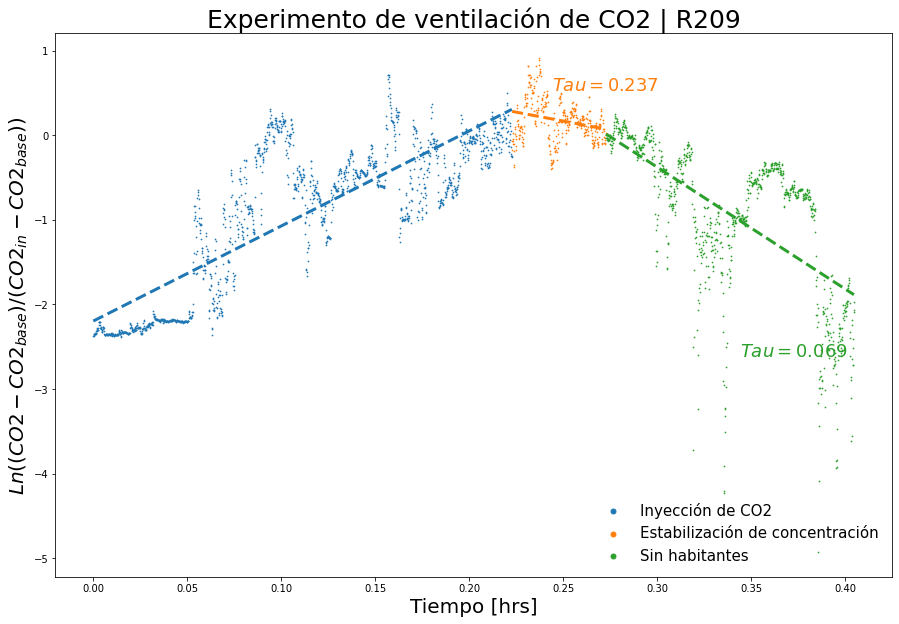

In [9]:
C_st_opendoor_licor = licor_IN_df["CO₂_(µmol_mol⁻¹)"][open_door_idx_lic]
C_st_end_licor = licor_IN_df["CO₂_(µmol_mol⁻¹)"][len(licor_IN_df["CO₂_(µmol_mol⁻¹)"])-1]

stop_inyec_idx_lic = licor_IN_df[licor_IN_df["System_Time_(h:m:s)"]==t_stopinyec_licor].index[-1]
open_door_idx_lic = licor_IN_df[licor_IN_df["System_Time_(h:m:s)"]==t_opendoor_licor].index[-1]

outdoor_CO2mean_lic = np.mean(licor_OUT_df["CO₂_(µmol_mol⁻¹)"][200:])

log_licor_normRIC = np.log((licor_IN_df["CO₂_(µmol_mol⁻¹)"]-outdoor_CO2mean_lic)/
                           (C_st_opendoor_licor-outdoor_CO2mean_lic))
log_licor_normRIC.dropna(inplace = True)

score = []
coef = []
inter = []

comparative_plot(log_licor_normRIC, stop_inyec_idx_lic, open_door_idx_lic, corr_tiempo_lic, 0.5, 
                 '$Ln( (CO2-CO2_{base})/(CO2_{in}-CO2_{base}) )$')

plt.title(f'Experimento de ventilación de CO2 | {infile_licor[0:4]}', fontsize = 25)

In [10]:
tau = [-1/tau for tau in coef]
tau_min = [t*60 for t in tau]
tau_min

[-5.334878518034955, 14.21759206079611, 4.1620020991312625]

In [11]:
dt_total =  pd.to_datetime('9:13:55') - pd.to_datetime('9:03:00')

ach_licor_tot = ach(C_st_opendoor_licor, C_st_end_licor, outdoor_CO2mean_lic, dt_total.total_seconds()/3600)
ach_licor_tot 

11.45399473044115